In [32]:
# Import packages
import pandas as pd
import numpy as np
import itertools
from collections import Counter

# Plots
import matplotlib.pyplot as plt
import pycountry
from countryinfo import CountryInfo
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import Dropdown, Output, VBox, Checkbox, HBox, Layout, IntRangeSlider, ToggleButtons
from IPython.display import display, HTML

# Clustering
import hdbscan
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans, HDBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
import seaborn as sns

# Imputer
from sklearn.impute import SimpleImputer


# Check for Missing Values and Duplicates

In [33]:
# Paths 2020 and 2024
csv_path2020_euroSciVoc = "../data/cordis-h2020projects-csv/euroSciVoc.csv"
csv_path2020_organization = "../data/cordis-h2020projects-csv/organization.csv"
csv_path2020_project = "../data/cordis-h2020projects-csv/project.csv"
csv_path2020_publication = "../data/cordis-h2020projects-csv/projectPublications2020.csv"
csv_path2020_publication_citation = "../data/cordis-h2020projects-csv/updated_publications_with_citations_2020.csv"

csv_path2024_euroSciVoc = "../data/cordis-HORIZONprojects-csv/euroSciVoc.csv"
csv_path2024_organization = "../data/cordis-HORIZONprojects-csv/organization.csv"
csv_path2024_project = "../data/cordis-HORIZONprojects-csv/project.csv"
csv_path2024_publication = "../data/cordis-HORIZONprojects-csv/projectPublications2024.csv"
csv_path2024_publication_citation = "../data/cordis-HORIZONprojects-csv/updated_publications_with_citations_2024.csv"


In [34]:
## for horizon 2020 MISSING VALUES AND DUPLICATES

# Dataframes inlezen
df2020_euroSciVoc = pd.read_csv(csv_path2020_euroSciVoc, delimiter=";", on_bad_lines="skip", low_memory=False)
df2020_organization = pd.read_csv(csv_path2020_organization, delimiter=";", on_bad_lines="skip", low_memory=False)
df2020_project = pd.read_csv(csv_path2020_project, delimiter=";", on_bad_lines="skip", low_memory=False)
df2020_publication = pd.read_csv(csv_path2020_publication,delimiter=";", on_bad_lines="skip", low_memory=False)
df2020_publication_citation = pd.read_csv(csv_path2020_publication_citation, delimiter=",", on_bad_lines="skip", low_memory=False)

# Verplichte kolommen per dataframe
cleaning_specs = {
    "df2020_project": ["id", "title", "startDate", "ecMaxContribution"],
    "df2020_organization": ["projectID", "organisationID", "role", "country", "ecContribution"],
    "df2020_euroSciVoc": ["projectID"],
    "df2020_publication": ["projectID", "doi"],
    #"df2020_publication_citation": ["doi", "title", "publishedYear", "citation_count"]
}

# Loop over alle dataframes en pas cleaning toe
for name, required_cols in cleaning_specs.items():
    df = globals()[name]
    df.drop_duplicates(inplace=True)
    df.dropna(subset=required_cols, inplace=True)


In [35]:

## for horizon 2024
# Dataframes inlezen
df2024_euroSciVoc = pd.read_csv(csv_path2024_euroSciVoc, delimiter=";", on_bad_lines="skip", low_memory=False)
df2024_organization = pd.read_csv(csv_path2024_organization, delimiter=";", on_bad_lines="skip", low_memory=False)
df2024_project = pd.read_csv(csv_path2024_project, delimiter=";", on_bad_lines="skip", low_memory=False)
df2024_publication=pd.read_csv(csv_path2024_publication,  delimiter=";", on_bad_lines="skip", low_memory=False)
df2024_publication_citation = pd.read_csv(csv_path2024_publication_citation, delimiter=",", on_bad_lines="skip", low_memory=False)

# Vereiste kolommen per df2024_... bestand
cleaning_specs_2024 = {
    "df2024_project": ["id", "title", "startDate", "ecMaxContribution"],
    "df2024_organization": ["projectID", "organisationID", "role", "country", "ecContribution"],
    "df2024_euroSciVoc": ["projectID"],
    "df2024_publication": ["projectID", "doi"],
    "df2024_publication_citation": ["doi", "title", "publishedYear", "citation_count"]
}

# Loop door elke dataframe en pas cleaning toe
for name, required_cols in cleaning_specs_2024.items():
    df = globals()[name]
    df.drop_duplicates(inplace=True)
    df.dropna(subset=required_cols, inplace=True)




In [36]:
# Add a 'source' column to each dataframe before concatenation

# PROJECT — analysis of time, category, and funding
df2020_project['source'] = '2020'
df2024_project['source'] = '2024'
df_project = pd.concat([df2020_project, df2024_project], ignore_index=True)

# ORGANIZATION — funding and coordinator roles per country
df2020_organization['source'] = '2020'
df2024_organization['source'] = '2024'
df_organization = pd.concat([df2020_organization, df2024_organization], ignore_index=True)

# EUROSCIVOC — linking projects to categories
df2020_euroSciVoc['source'] = '2020'
df2024_euroSciVoc['source'] = '2024'
df_euroSciVoc = pd.concat([df2020_euroSciVoc, df2024_euroSciVoc], ignore_index=True)

# PUBLICATION — project-related research output
df2020_publication['source'] = '2020'
df2024_publication['source'] = '2024'
df_publication = pd.concat([df2020_publication, df2024_publication], ignore_index=True)

# PUBLICATION CITATION — citation data for publications
df2020_publication_citation['source'] = '2020'
df2024_publication_citation['source'] = '2024'
df_publication_citation = pd.concat([df2020_publication_citation.drop_duplicates(), df2024_publication_citation.drop_duplicates()], ignore_index=True)

# (Optional) Print shapes to confirm
print("df_project shape:", df_project.shape)
print("df_organization shape:", df_organization.shape)
print("df_euroSciVoc shape:", df_euroSciVoc.shape)
print("df_publication shape:", df_publication.shape)
print("df_publication_citation shape:", df_publication_citation.shape)

df_project shape: (50315, 21)
df_organization shape: (254699, 26)
df_euroSciVoc shape: (152982, 6)
df_publication shape: (377900, 17)
df_publication_citation shape: (377899, 18)


In [37]:
# Extract category from the concatenated dataframe
df_euroSciVoc['category'] = df_euroSciVoc['euroSciVocPath'].str.split('/').str[1]
# Count rows per category in the concatenated dataframe
category_counts = df_euroSciVoc[['category','source']].value_counts().reset_index()
# Choose column names
category_counts.columns = ['category', 'source', 'count']

df_project['startYear'] = pd.to_datetime(df_project['startDate'], errors='coerce').dt.year
df_project_cat = df_euroSciVoc.merge(df_project, left_on='projectID', right_on='id')


# Count projects per category per year
category_per_year = df_project_cat.groupby(['startYear', 'category']).size().reset_index(name='project_count')

# Fix year column format
category_per_year['Year'] = category_per_year['startYear'].astype('Int64')
category_per_year = category_per_year.drop(columns='startYear')


# Print 
print("\nNumber of projects per category:")
print(category_counts.to_string(index=False))

# Print
print(category_per_year.sort_values(['Year', 'project_count'], ascending=[True, False]).to_string(index=False))

df_organization['year'] = pd.to_datetime(df_organization['projectID'].map(
    df_project.set_index('id')['startDate']
), errors='coerce').dt.year
available_years = sorted(df_organization['year'].dropna().unique().astype(int))

df_project['startYear'] = pd.to_datetime(df_project['startDate'], errors='coerce').dt.year
df_organization['year'] = df_organization['projectID'].map(df_project.set_index('id')['startYear'])

category_per_year.to_csv("../data/category_per_year.csv", index = False)



Number of projects per category:
                   category source  count
           natural sciences   2020  48421
 engineering and technology   2020  25267
           natural sciences   2024  18075
medical and health sciences   2020  17468
            social sciences   2020  16024
 engineering and technology   2024   6680
medical and health sciences   2024   5985
            social sciences   2024   5027
                 humanities   2020   4028
      agricultural sciences   2020   2985
                 humanities   2024   1739
      agricultural sciences   2024   1283
                   category  project_count  Year
 engineering and technology            351  2014
           natural sciences            213  2014
            social sciences            165  2014
medical and health sciences            127  2014
      agricultural sciences             24  2014
                 humanities              6  2014
           natural sciences           7656  2015
 engineering and technology 

In [38]:
# Prepare data: count projects per category per year
category_counts = (
    df_project_cat.groupby(['startYear', 'category'])
    .size()
    .reset_index(name='project_count')
    .dropna(subset=['startYear', 'category'])
)

# Get available years
years = sorted(category_counts['startYear'].dropna().unique())
# Alle categorieën
categories = sorted(category_per_year['category'].dropna().unique())

# Group by country and sum contributions
funding = df_organization.groupby('country')[['ecContribution', 'netEcContribution']].sum().reset_index()
funding.to_csv("../data/merged_funding.csv", index=False)


In [39]:
df_publication_citation['projectID'] = pd.to_numeric(df_publication_citation['projectID'], errors='coerce')

df_euroSciVoc['projectID'] = df_euroSciVoc['projectID']
# Merge publications with project categories
df_pubs_cat = pd.merge(df_publication_citation, df_euroSciVoc[['projectID', 'category']], on='projectID', how='left')

# Use publishedYear as 'Year'
df_pubs_cat['Year'] = pd.to_numeric(df_pubs_cat['publishedYear'], errors='coerce').astype('Int64')

# Prepare data: count publications and sum citations per category per year
category_year_stats = (
    df_pubs_cat
    .groupby(['category', 'Year'])
    .agg(
        publication_count=('id', 'count'),
        total_citations=('citation_count', 'sum')
    )
    .reset_index()
)

In [40]:
# Step 1: Replace -1 with np.nan for imputation
df_publication_citation['citation_count'] = df_publication_citation['citation_count'].replace(-1, np.nan)

# Count how many will be purged (no valid citation_count in project)
valid_counts = df_publication_citation.groupby('projectID')['citation_count'].transform(lambda x: x.notna().sum())
purge_mask = (df_publication_citation['citation_count'].isna()) & (valid_counts == 0)
n_purged = purge_mask.sum()

# Remove these rows
df_publication_citation = df_publication_citation[~purge_mask].copy()

# Count how many will be substituted (missing but project has valid values)
substitute_mask = df_publication_citation['citation_count'].isna()
n_substituted = substitute_mask.sum()

# Impute missing citation_count with project mean (using sklearn)
from sklearn.impute import SimpleImputer

def impute_group_mean(group):
    imputer = SimpleImputer(strategy='mean')
    group['citation_count'] = imputer.fit_transform(group[['citation_count']])
    return group

df_publication_citation = df_publication_citation.groupby('projectID', group_keys=False).apply(impute_group_mean)

print(f"Number of citation counts substituted with project mean: {n_substituted}")
print(f"Number of publications purged (no valid citation_count in project): {n_purged}")
# Prepare data: sum citations per category per year
citations_per_topic_year = (
    df_pubs_cat
    .groupby(['Year', 'category'])
    .agg(total_citations=('citation_count', 'sum'))
    .reset_index()
)

/var/folders/4v/zr3kb4917zn6dghk4y1t743w0000gn/T/ipykernel_93300/3174703022.py:24: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Number of citation counts substituted with project mean: 19843
Number of publications purged (no valid citation_count in project): 800


# Analyse of research priorities

In [10]:
dropdown_year = Dropdown(
    options=years,
    value=years[0] if years else None,
    description='Year:'
)

out_pie = Output()

def plot_pie(selected_year):
    data = category_counts[category_counts['startYear'] == selected_year]
    if data.empty:
        return None
    fig = px.pie(
        data,
        names='category',
        values='project_count',
        title=f'Project Distribution by Research Category ({selected_year})',
        hole=0.3
    )
    fig.update_traces(textinfo='percent+label')
    return fig

def update_pie(change):
    with out_pie:
        out_pie.clear_output(wait=True)
        fig = plot_pie(change['new'])
        if fig:
            display(fig)
        else:
            print("No data for this year.")

dropdown_year.observe(update_pie, names='value')

display(VBox([dropdown_year, out_pie]))

# Initial plot
with out_pie:
    fig = plot_pie(dropdown_year.value)
    if fig:
        display(fig)
    else:
        print("No data for this year.")

In [11]:
# Output-widget
out = Output()

# Dropdown-widget
dropdown = Dropdown(
    options=categories,
    value='engineering and technology',
    description='Categorie:'
)

# Plotfunctie
def create_plot(selected_cat):
    data = category_per_year[category_per_year['category'] == selected_cat]
    fig = px.line(
        data,
        x='Year',
        y='project_count',
        markers=True,
        title=f'{selected_cat.capitalize()} Projects Over Time',
        labels={'project_count': 'Number of Projects'}
    )
    fig.update_layout(
        height=500,
        margin={"r": 0, "t": 50, "l": 0, "b": 0}
    )
    return fig

# Update-functie
def update_plot(change):
    with out:
        out.clear_output(wait=True)
        selected = change['new']
        fig = create_plot(selected)
        display(fig)

# Koppel de update-functie aan dropdown
dropdown.observe(update_plot, names='value')

# UI tonen
display(VBox([dropdown, out]))

# Initieel plot weergeven
with out:
    fig = create_plot(dropdown.value)
    display(fig)


# Contribution maps

In [12]:
# ISO2 naar ISO3
def convert_iso2_to_iso3(iso2_code):
    try:
        return pycountry.countries.get(alpha_2=iso2_code).alpha_3
    except:
        return None


In [13]:

# Kaartfunctie
def create_map(data, funding_column):
    data = data.copy()
    data["iso_alpha"] = data["country"].apply(convert_iso2_to_iso3)
    fig = px.scatter_geo(
        data,
        locations="iso_alpha",
        locationmode="ISO-3",
        size=funding_column,
        hover_name="country",
        projection="natural earth",
        title=f"Funding Levels",
        size_max=50
    )
    fig.update_geos(
        showcountries=True,
        countrycolor="LightGray",
        showcoastlines=True,
        coastlinecolor="LightGray",
    )
    fig.update_layout(
        margin={"r": 0, "t": 50, "l": 0, "b": 0},
        height=600,
    )
    return fig

# Output-widget
out = Output()

# Range sliders for year selection
year_range = IntRangeSlider(
    value=[min(available_years), max(available_years)],
    min=min(available_years),
    max=max(available_years),
    step=1,
    description='Years:',
    continuous_update=False
)

def update_map(change=None):
    with out:
        out.clear_output(wait=True)
        start_year, end_year = year_range.value
        contrib_type = 'netEcContribution'

        # Filter organizations by project start year
        orgs = df_organization[
            (df_organization['year'] >= start_year) &
            (df_organization['year'] <= end_year)
        ]

        # Group by country and sum contributions
        funding = orgs.groupby('country')[contrib_type].sum().reset_index()
        funding.columns = ['country', f'{contrib_type}_sum']
        if funding.empty:
            print("No data for selected period.")
            return
        fig = create_map(funding, f'{contrib_type}_sum')
        fig.update_layout(title=f"Net EC Contribution {start_year}-{end_year}")
        display(fig)

year_range.observe(update_map, names='value')

display(VBox([year_range, out]))

update_map()

## Network analysis

In [14]:

def country_network_matrices(df, id_col='projectID', country_col='country'):
    """
    Build:
      • network_df  : symmetric country‑by‑country co‑operation counts
      • distance_df : 1 – 1/n transformation of network_df
      • norm_df     : distance_df normalised by row+column totals
    Returns the three dataframes in that order.
    """

    # ── 1. Project‑country incidence matrix (binary) ────────────────────────────
    incidence = (df[[id_col, country_col]]
                 .drop_duplicates()              # one flag per project–country
                 .assign(val=1)
                 .pivot(index=id_col, columns=country_col, values='val')
                 .fillna(0)
                 .astype(int))

    # ── 2. Co‑operation counts between countries (adjacency) ───────────────────
    network_df = incidence.T @ incidence          # matrix multiplication
    np.fill_diagonal(network_df.values, 0)        # remove self‑loops
    network_df = network_df.astype(int)

    # ── 3. Distance matrix: linear with max collaborations ─────────────────────
    INF = 1e3  # a large number to represent no collaboration
    with np.errstate(divide='ignore', invalid='ignore'):
        distance_arr = 1 / network_df.values
        distance_arr[network_df.values == 0] = INF  # Set distance to 1 if no collaboration
    dissimilarity_df = pd.DataFrame(distance_arr, index=network_df.index, columns=network_df.columns)

    return network_df, dissimilarity_df


In [15]:

def country_network_matrices_maxcollab(df, id_col='projectID', country_col='country'):
    """
    Build:
      • network_df  : symmetric country‑by‑country co‑operation counts
      • distance_df : 1 – 1/n transformation of network_df
      • norm_df     : distance_df normalised by row+column totals
    Returns the three dataframes in that order.
    """

    # ── 1. Project‑country incidence matrix (binary) ────────────────────────────
    incidence = (df[[id_col, country_col]]
                 .drop_duplicates()              # one flag per project–country
                 .assign(val=1)
                 .pivot(index=id_col, columns=country_col, values='val')
                 .fillna(0)
                 .astype(int))

    # ── 2. Co‑operation counts between countries (adjacency) ───────────────────
    network_df = incidence.T @ incidence          # matrix multiplication
    np.fill_diagonal(network_df.values, 0)        # remove self‑loops
    network_df = network_df.astype(int)

    # ── 3. Distance matrix: linear with max collaborations ─────────────────────
    max_collab = network_df.values.max()
    INF = 1e3  # a large number to represent no collaboration
    if max_collab == 0:
        Exception("No collaborations found in the data.")
    else:
        dissimilarity_df = (max_collab - network_df + 1) / max_collab # +1 to avoid 0 dissimilarity between distinct countries
        dissimilarity_df[network_df.values == 0] = INF  # Set to 2 if no collaboration

    return network_df, dissimilarity_df


In [16]:
def country_network_matrices_nonisolated(df, id_col='projectID', country_col='country'):
    """
    Build:
      • network_df  : symmetric country‑by‑country co‑operation counts (no isolated countries)
      • distance_df : 1 + 1/n transformation of network_df (no isolated countries)
    Returns the two dataframes in that order.
    """

    # 1. Project‑country incidence matrix (binary)
    incidence = (df[[id_col, country_col]]
                 .drop_duplicates()
                 .assign(val=1)
                 .pivot(index=id_col, columns=country_col, values='val')
                 .fillna(0)
                 .astype(int))

    # 2. Co‑operation counts between countries (adjacency)
    network_df = incidence.T @ incidence
    np.fill_diagonal(network_df.values, 0)
    network_df = network_df.astype(int)

    # Remove countries (rows/cols) with only zeros
    nonisolated = (network_df.sum(axis=0) > 0) | (network_df.sum(axis=1) > 0)
    network_df = network_df.loc[nonisolated, nonisolated]

    # 3. Distance matrix: 1/(1+n), handle n=0
    INF = 1e3  # a large number to represent no collaboration
    with np.errstate(divide='ignore', invalid='ignore'):
        distance_arr = 1 / (network_df.values)
        distance_arr[network_df.values == 0] = INF  # Set distance to 1 if no collaboration
    dissimilarity_df = pd.DataFrame(distance_arr, index=network_df.index, columns=network_df.columns)

    return network_df, dissimilarity_df

In [17]:
def country_network_matrices_nonisolated_maxcollab(df, id_col='projectID', country_col='country'):
    """
    Build:
      • network_df  : symmetric country‑by‑country co‑operation counts (no isolated countries)
      • distance_df : (max_collab - n + 1) / max_collab, but set to 2 if no collaboration
    Returns the two dataframes in that order.
    """

    # 1. Project‑country incidence matrix (binary)
    incidence = (df[[id_col, country_col]]
                 .drop_duplicates()
                 
                 .assign(val=1)
                 .pivot(index=id_col, columns=country_col, values='val')
                 .fillna(0)
                 .astype(int))

    # 2. Co‑operation counts between countries (adjacency)
    network_df = incidence.T @ incidence
    np.fill_diagonal(network_df.values, 0)
    network_df = network_df.astype(int)

    # Remove countries (rows/cols) with only zeros
    nonisolated = (network_df.sum(axis=0) > 0) | (network_df.sum(axis=1) > 0)
    network_df = network_df.loc[nonisolated, nonisolated]

    # 3. Distance matrix: (max_collab - n + 1) / max_collab, set to 2 if n==0
    INF = 1e3  # a large number to represent no collaboration
    max_collab = network_df.values.max()
    if max_collab == 0:
        raise Exception("No collaborations found in the data.")
    else:
        dissimilarity_arr = (max_collab - network_df.values + 1) / max_collab
        dissimilarity_arr[network_df.values == 0] = INF  # Set to 2 if no collaboration
        dissimilarity_df = pd.DataFrame(dissimilarity_arr, index=network_df.index, columns=network_df.columns)

    return network_df, dissimilarity_df

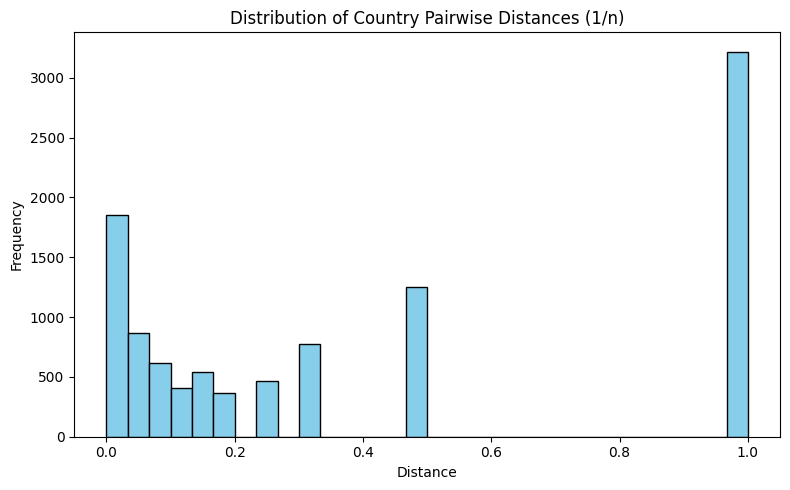

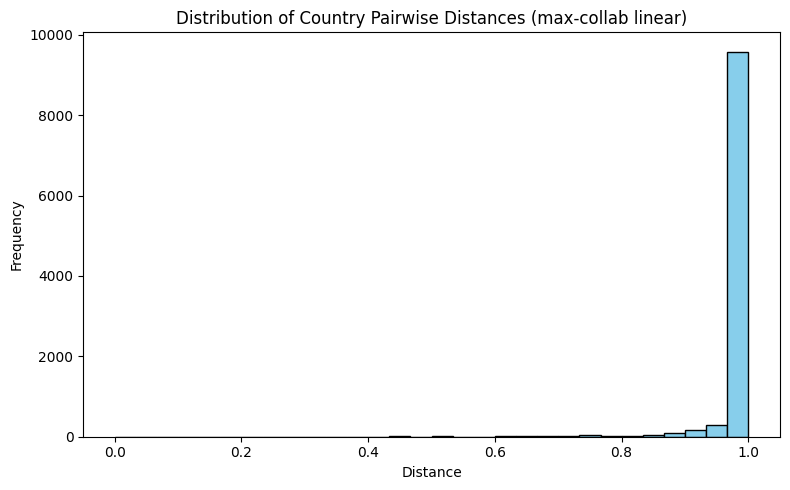

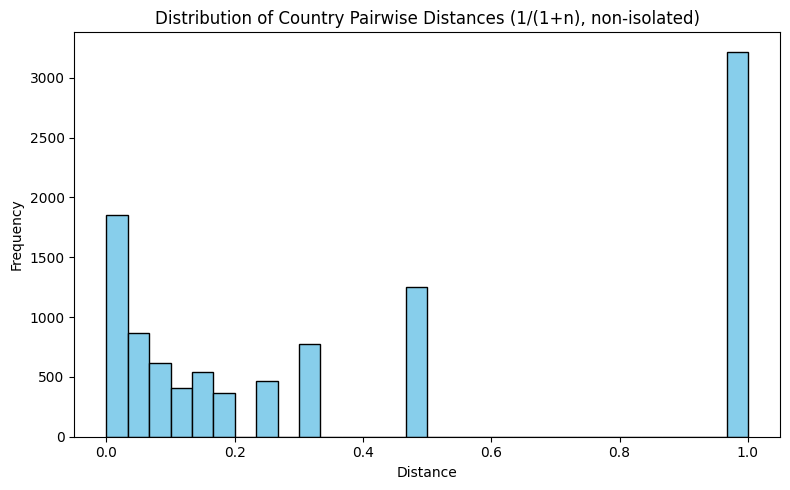

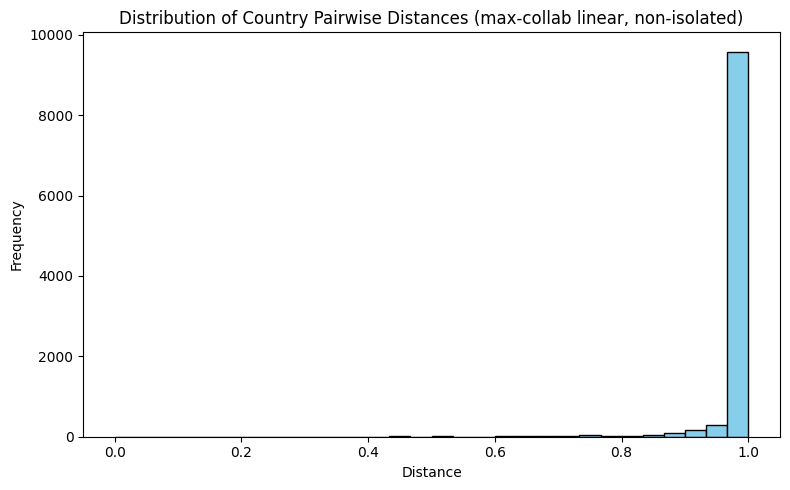

In [18]:
def plot_distance_histogram(distance_func, df, title):
    INF = 1e3  # a large number to represent no collaboration
    _, dissimilarity_df = distance_func(df)
    distances = dissimilarity_df.values
    off_diag_distances = distances[~np.eye(distances.shape[0], dtype=bool)]
    off_diag_distances = off_diag_distances[off_diag_distances != INF]
    plt.figure(figsize=(8, 5))
    plt.hist(off_diag_distances, bins=30, color='skyblue', edgecolor='black')
    plt.title(title)
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# List of (function, title) pairs
distance_metrics = [
    (country_network_matrices, "Distribution of Country Pairwise Distances (1/n)"),
    (country_network_matrices_maxcollab, "Distribution of Country Pairwise Distances (max-collab linear)"),
    (country_network_matrices_nonisolated, "Distribution of Country Pairwise Distances (1/(1+n), non-isolated)"),
    (country_network_matrices_nonisolated_maxcollab, "Distribution of Country Pairwise Distances (max-collab linear, non-isolated)")
]

for func, title in distance_metrics:
    plot_distance_histogram(func, df_organization, title)


In [19]:
def plot_silhouette_for_year(selected_year, min_k=2, max_k=10):
    # Filter organizations for the selected year
    project_ids = df_project[df_project['startYear'] == selected_year]['id']
    df_filtered_org = df_organization[df_organization['projectID'].isin(project_ids)]
    if df_filtered_org.empty:
        print("No projects found for the selected year.")
        return

    _, dissimilarity_df = country_network_matrices_nonisolated(df_filtered_org)
    X = dissimilarity_df.values

    silhouette_avgs = []
    Ks = range(min_k, min(max_k, len(X)))
    for k in Ks:
        kmeans = KMeans(n_clusters=k, n_init="auto", random_state=42)
        labels = kmeans.fit_predict(X)
        if len(set(labels)) == 1:
            silhouette_avgs.append(-1)
        else:
            score = silhouette_score(X, labels, metric='euclidean')
            silhouette_avgs.append(score)

    plt.figure(figsize=(7, 4))
    plt.plot(Ks, silhouette_avgs, marker='o')
    plt.title(f'Silhouette Score per K (year={selected_year})')
    plt.xlabel('Number of clusters (K)')
    plt.ylabel('Average silhouette score')
    plt.grid(True)
    plt.show()

    # Optional: Silhouette plot for the best K
    best_k = Ks[np.argmax(silhouette_avgs)]
    kmeans = KMeans(n_clusters=best_k, n_init="auto", random_state=42)
    labels = kmeans.fit_predict(X)
    sample_silhouette_values = silhouette_samples(X, labels)
    y_lower = 10
    plt.figure(figsize=(7, 5))
    for i in range(best_k):
        ith_cluster_silhouette_values = sample_silhouette_values[labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values)
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    plt.title(f'Silhouette Plot for K={best_k} (year={selected_year})')
    plt.xlabel('Silhouette coefficient values')
    plt.ylabel('Cluster')
    plt.axvline(x=np.mean(sample_silhouette_values), color="red", linestyle="--")
    plt.show()
    print(f"Best K: {best_k} (highest average silhouette score: {max(silhouette_avgs):.3f})")

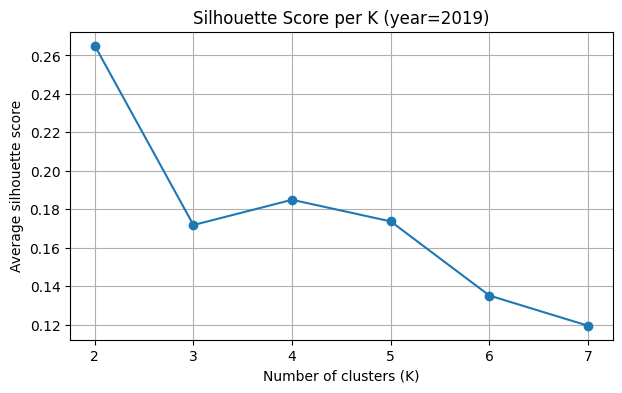

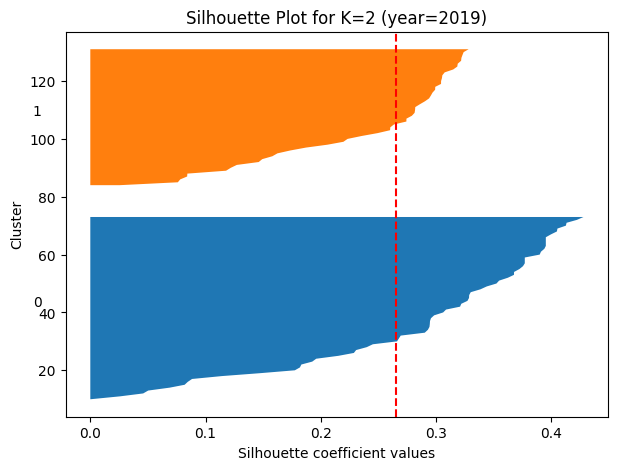

Best K: 2 (highest average silhouette score: 0.265)


In [20]:
# Example: for year 2019
plot_silhouette_for_year(2019, min_k=2, max_k=8)

Clustering: K-Means, HDBScan, Agglomerative

In [21]:
selected_year = 2017
network_df, dissimilarity_df = country_network_matrices_nonisolated(df_organization[df_organization['year']==selected_year])

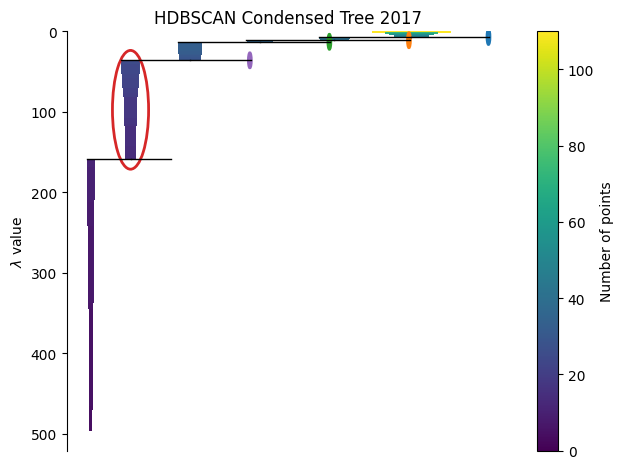

In [22]:
# HDBSCAN expects a condensed distance matrix

clusterer = hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=2)
clusterer.fit(dissimilarity_df.values)

# Plot the condensed tree (dendrogram-like)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())
plt.title(f'HDBSCAN Condensed Tree {selected_year}')
plt.tight_layout()
plt.show()

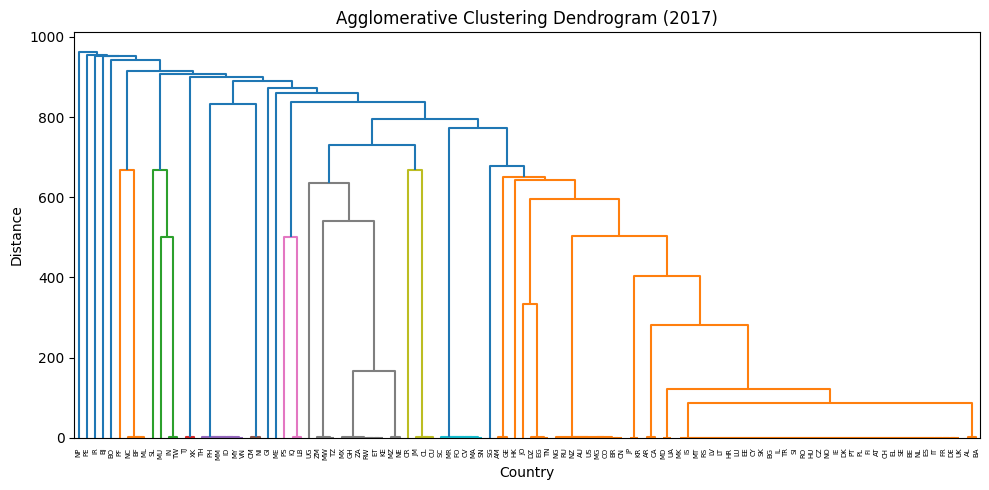

In [23]:
# Prepare dissimilarity matrix for the selected year
project_ids = df_project[df_project['startYear'] == selected_year]['id']
df_filtered_org = df_organization[df_organization['projectID'].isin(project_ids)]
_, dissimilarity_df = country_network_matrices_nonisolated(df_filtered_org)

# Convert to condensed distance matrix for linkage
dissimilarity_condensed = squareform(dissimilarity_df.values, checks=False)
Z = linkage(dissimilarity_condensed, method='average')

plt.figure(figsize=(10, 5))
dendrogram(Z, labels=dissimilarity_df.index.tolist(), leaf_rotation=90)
plt.title(f'Agglomerative Clustering Dendrogram ({selected_year})')
plt.xlabel('Country')
plt.ylabel('Distance')
plt.tight_layout()
plt.show()

In [24]:


# Clusteringfunctie
def cluster_dataframe(dissimilarity_df: pd.DataFrame, algo, name: str) -> pd.DataFrame:
    if getattr(algo, "metric", None) == "precomputed" or getattr(algo, "affinity", "") == "precomputed":
        algo.fit(dissimilarity_df)
    else:
        algo.fit(dissimilarity_df.values)

    return (
        pd.DataFrame({
            "country": dissimilarity_df.index,
            "cluster": algo.labels_.astype(str)
        })
        .assign(iso_alpha=lambda df: df["country"].map(iso2_to_iso3))
        .dropna(subset=["iso_alpha"])
    )

# Plotfunctie
def cluster_map(df: pd.DataFrame, title: str) -> px.choropleth:
    fig = px.choropleth(
        df,
        locations="iso_alpha",
        color="cluster",
        hover_name="country",
        color_discrete_sequence=px.colors.qualitative.Set3,
        projection="natural earth",
        title=title
    )
    fig.update_geos(showcountries=True, countrycolor="LightGray",
                    showcoastlines=True, coastlinecolor="Gray")
    fig.update_layout(margin=dict(r=0, l=0, t=50, b=0))
    return fig

# Kernfunctie: clustering voor één jaar en methode
def cluster_projects_for_year(selected_year: int, method: str) -> list:
    df_project['startDate'] = pd.to_datetime(df_project['startDate'], errors='coerce')
    project_ids = df_project[df_project['startDate'].dt.year == selected_year]['id']
    df_filtered_org = df_organization[df_organization['projectID'].isin(project_ids)]

    if df_filtered_org.empty:
        return []

    _, dissimilarity_df = country_network_matrices(df_filtered_org)

    clusterers = {
        "K-means":   KMeans(n_clusters=5, n_init="auto", random_state=42),
        "HDBSCAN":   hdbscan.HDBSCAN(metric='precomputed', min_cluster_size=2),
        "Agglomerative": AgglomerativeClustering(n_clusters=5, metric="precomputed", linkage="single"),
    }

    figs = []
    if method in clusterers:
        algo = clusterers[method]
        input_matrix = 1/dissimilarity_df if method == "Spectral" else dissimilarity_df
        df_clustered = cluster_dataframe(input_matrix, algo, method)
        fig = cluster_map(df_clustered, f"{method} clustering — international cooperation ({selected_year})")
        figs.append(fig)
    return figs

# Unieke jaartallen ophalen
df_combined = df_project.copy()
df_combined['startDate'] = pd.to_datetime(df_combined['startDate'], errors='coerce')
available_years = sorted(df_combined['startDate'].dt.year.dropna().unique().astype(int))

# UI: dropdowns + output
dropdown_year = Dropdown(
    options=available_years,
    value=available_years[0],
    description='Starting Year:'
)

dropdown_method = Dropdown(
    options=['K-means', 'HDBSCAN', 'Agglomerative'],
    value='K-means',
    description='Method:'
)

out = Output()

def update_plot(change=None):
    with out:
        out.clear_output(wait=True)
        year = dropdown_year.value
        method = dropdown_method.value
        figs = cluster_projects_for_year(year, method)
        if figs:
            for fig in figs:
                display(HTML(fig.to_html(include_plotlyjs='cdn')))
        else:
            print("No projects found for the selected year or method.")

dropdown_year.observe(update_plot, names='value')
dropdown_method.observe(update_plot, names='value')

display(VBox([dropdown_year, dropdown_method, out]))

with out:
    initial_figs = cluster_projects_for_year(dropdown_year.value, dropdown_method.value)
    for fig in initial_figs:
        display(HTML(fig.to_html(include_plotlyjs='cdn')))

In [25]:
# 1. Prepare the full network matrix for all years
network_df, dissimilarity_df = country_network_matrices(df_organization)

# 2. Run K-means clustering (choose K, e.g., 5)
kmeans = KMeans(n_clusters=5, n_init="auto", random_state=42)
labels = kmeans.fit_predict(dissimilarity_df.values)

# 3. Prepare a DataFrame with country, cluster, and ISO3 code for plotting

clusters_df = pd.DataFrame({
    "country": dissimilarity_df.index,
    "cluster": labels.astype(str)
})
clusters_df["iso_alpha"] = clusters_df["country"].map(iso2_to_iso3)
clusters_df = clusters_df.dropna(subset=["iso_alpha"])

# 4. (Optional) Plot the clusters on a map
fig = px.choropleth(
    clusters_df,
    locations="iso_alpha",
    color="cluster",
    hover_name="country",
    color_discrete_sequence=px.colors.qualitative.Set3,
    projection="natural earth",
    title="K-means clustering — international cooperation (all years)"
)
fig.update_geos(showcountries=True, countrycolor="LightGray",
                showcoastlines=True, coastlinecolor="Gray")
fig.update_layout(margin=dict(r=0, l=0, t=50, b=0))
fig.show()

# Save the network DataFrame to a CSV file
network_df.to_csv("../data/network_df.csv", index=True)
# Save the clusters DataFrame to a CSV file
clusters_df.to_csv("../data/clusters_df.csv", index=False)

NameError: name 'iso2_to_iso3' is not defined

## Network analysis

In [ ]:
def get_lat_lon_from_iso2(iso2):
    try:
        info = CountryInfo(iso2)
        latlng = info.latlng()
        if latlng and len(latlng) == 2:
            return latlng[0], latlng[1]
    except Exception:
        pass
    return None, None

In [ ]:
from ipywidgets import Dropdown, Output, VBox, IntRangeSlider
from IPython.display import display
import plotly.graph_objects as go

def get_lat_lon_from_iso2(iso2):
    try:
        info = CountryInfo(iso2)
        latlng = info.latlng()
        if latlng and len(latlng) == 2:
            return latlng[0], latlng[1]
    except Exception:
        pass
    return None, None

# Year range slider
year_range = IntRangeSlider(
    value=[years[0], years[-1]],
    min=years[0],
    max=years[-1],
    step=1,
    description='Years:',
    continuous_update=False
)

dropdown_cluster = Dropdown(description='Cluster:')
out_links = Output()

def update_cluster_network(*args):
    start_year, end_year = year_range.value
    # Filter projects and organizations by year range
    project_ids = df_project[(df_project['startYear'] >= start_year) & (df_project['startYear'] <= end_year)]['id']
    df_filtered_org = df_organization[df_organization['projectID'].isin(project_ids)]

    if df_filtered_org.empty:
        with out_links:
            out_links.clear_output()
            print("No data for selected period.")
        dropdown_cluster.options = []
        return

    # Recompute network and clusters for selected years
    network_df, dissimilarity_df = country_network_matrices(df_filtered_org)
    clusters_df = cluster_dataframe(dissimilarity_df, KMeans(n_clusters=5, n_init="auto", random_state=42), "K-means")

    # Update cluster dropdown options
    cluster_options = sorted(clusters_df['cluster'].unique())
    dropdown_cluster.options = cluster_options
    dropdown_cluster.value = cluster_options[0] if cluster_options else None

    def plot_cluster_links(selected_cluster):
        with out_links:
            out_links.clear_output(wait=True)
            countries = clusters_df[clusters_df['cluster'] == selected_cluster]['country'].tolist()
            if len(countries) < 2:
                print("Not enough countries in this cluster to show links.")
                return

            coords = {}
            for c in countries:
                lat, lon = get_lat_lon_from_iso2(c)
                if lat is not None and lon is not None:
                    coords[c] = (lat, lon)
            valid_countries = [c for c in countries if c in coords]

            lines = []
            weights = []
            for i, c1 in enumerate(valid_countries):
                for j, c2 in enumerate(valid_countries):
                    if j <= i:
                        continue
                    weight = network_df.loc[c1, c2]
                    if weight > 0:
                        lines.append({
                            'from': c1,
                            'to': c2,
                            'weight': weight,
                            'from_lat': coords[c1][0],
                            'from_lon': coords[c1][1],
                            'to_lat': coords[c2][0],
                            'to_lon': coords[c2][1],
                        })
                        weights.append(weight)

            lats = [coords[c][0] for c in valid_countries]
            lons = [coords[c][1] for c in valid_countries]
            names = [c for c in valid_countries]

            fig = go.Figure()

            # Color lines by weight using red with varying alpha (transparency)
            if lines:
                min_w, max_w = min(weights), max(weights)

                def get_rgba(val):
                    # Normalize weight to [0, 1]
                    if max_w == min_w:
                        t = 1.0
                    else:
                        t = (val - min_w) / (max_w - min_w)
                    # Red color, alpha from 0.1 (almost transparent) to 1 (opaque)
                    alpha = 0.1 + 0.9 * t
                    return f'rgba(220, 20, 60, {alpha:.2f})'  # Crimson red

                for link in lines:
                    color = get_rgba(link['weight'])
                    fig.add_trace(go.Scattergeo(
                        lon=[link['from_lon'], link['to_lon']],
                        lat=[link['from_lat'], link['to_lat']],
                        mode='lines',
                        line=dict(width=3, color=color),
                        opacity=1.0,  # Opacity handled by RGBA
                        showlegend=False,
                        hoverinfo='text',
                        text=f"{link['from']}–{link['to']}: {link['weight']}"
                    ))

            fig.add_trace(go.Scattergeo(
                lon=lons,
                lat=lats,
                mode='markers+text',
                marker=dict(size=10, color='blue'),
                text=names,
                textposition="top center",
                hoverinfo='text'
            ))
            fig.update_geos(
                showcountries=True,
                countrycolor="LightGray",
                showcoastlines=True,
                coastlinecolor="Gray",
                projection_type="natural earth"
            )
            fig.update_layout(
                title=f"Collaboration Links in Cluster {selected_cluster} ({start_year}-{end_year})",
                height=600,
                margin=dict(r=0, l=0, t=50, b=0)
            )
            display(fig)

    dropdown_cluster.observe(lambda change: plot_cluster_links(change['new']), names='value')
    if dropdown_cluster.value is not None:
        plot_cluster_links(dropdown_cluster.value)
    else:
        with out_links:
            out_links.clear_output()
            print("No clusters for selected period.")

# Observe year slider
year_range.observe(update_cluster_network, names='value')

# Initial UI
display(VBox([year_range, dropdown_cluster, out_links]))
update_cluster_network()

## Research Impact

In [26]:
# Widget output
out = Output()

# All categories
categories = sorted(category_year_stats['category'].dropna().unique())

# Dropdown widget
dropdown = Dropdown(
    options=categories,
    value=categories[0] if categories else None,
    description='Categorie:'
)

# Plot function
def create_plot(selected_cat):
    data = category_year_stats[category_year_stats['category'] == selected_cat]
    fig = px.line(
        data,
        x='Year',
        y='publication_count',
        markers=True,
        title=f'{selected_cat.capitalize()} Publications Over Time',
        labels={'publication_count': 'Number of Publications'}
    )
    # Add citations as secondary y-axis
    fig.add_bar(
        x=data['Year'],
        y=data['total_citations'],
        name='Total Citations',
        yaxis='y2',
        marker_color='orange',
        opacity=0.5
    )
    fig.update_layout(
        height=500,
        margin={"r": 0, "t": 50, "l": 0, "b": 0},
        yaxis=dict(title='Number of Publications'),
        yaxis2=dict(
            title='Total Citations',
            overlaying='y',
            side='right'
        ),
        legend=dict(x=0.01, y=0.99)
    )
    return fig

# Update function
def update_plot(change):
    with out:
        out.clear_output(wait=True)
        selected = change['new']
        fig = create_plot(selected)
        display(fig)

# Link update function to dropdown
dropdown.observe(update_plot, names='value')

# Show UI
display(VBox([dropdown, out]))

# Initial plot
with out:
    if categories:
        fig = create_plot(dropdown.value)
        display(fig)
    else:
        print("No categories available.")

In [27]:
# Dropdown for year selection
dropdown_year = Dropdown(
    options=years,
    value=years[0] if years else None,
    description='Year:'
)

out_pie = Output()

def plot_pie(selected_year):
    data = citations_per_topic_year[citations_per_topic_year['Year'] == selected_year]
    if data.empty:
        fig = None
    else:
        fig = px.pie(
            data,
            names='category',
            values='total_citations',
            title=f'Citations by Research Topic in {selected_year}',
            hole=0.3
        )
        fig.update_traces(textinfo='percent+label')
    return fig

def update_pie(change):
    with out_pie:
        out_pie.clear_output(wait=True)
        fig = plot_pie(change['new'])
        if fig:
            display(fig)
        else:
            print("No data for this year.")

dropdown_year.observe(update_pie, names='value')

display(VBox([dropdown_year, out_pie]))

# Initial plot
with out_pie:
    fig = plot_pie(dropdown_year.value)
    if fig:
        display(fig)
    else:
        print("No data for this year.")